In [1]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility
 # Only use this line to show in jupyter
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer

Using Theano backend.


In [3]:
max_words = 1000
batch_size = 32
nb_epoch = 10

In [4]:
# list_of_tuples = [(1, 'a'), (1, 'b'), (2, 'a'), (2, 'b')]
# list_of_tuples.sort(key=lambda t:(t[1], -t[0]))
# print(list_of_tuples) # [(2, 'a'), (1, 'a'), (2, 'b'), (1, 'b')]

In [5]:
# building the global vocabulary index
def build_voc(files):
    word_freq = {}
    for file in files:
        f = open(file, 'r')
        for line in f:
            els = line.split('\t')
            for word in els[1].strip().split(' '):
                if word not in word_freq:
                    word_freq[word] = 0
                word_freq[word] += 1
    
    word_freq = sorted(word_freq.items(), key=lambda x: (-x[1], x[0]))
    return word_freq

# loading the dataset for training and testing
def load_data(file,voc,nb_words):
    classes = []    
    word_index_max = []  
    word_index = []
    count=0
    for x in voc:
        if count < nb_words :
            word_index_max.append(x[0])
        word_index.append(x[0])
        count += 1
    
    train_file = open(file,'r')
    X_train = []
    Y_train = []
    
    # load the data in 2 lists to index
    for line in train_file:
        els = line.split('\t')
        # tranform classes as indexes
        classes.append(els[0])
    
    # set and sorted on classes
    classes = sorted(set(classes))    
    
    # encode the words based on the word_index
    train_file = open(file,'r')
    for line in train_file:
        els = line.split('\t')
        Y_train.append(classes.index(els[0]))
        words = []
        words.append(1)
        
        # X is a list of word index sentences, index are ordered by frequence, 1 is the most frequent word
        # Add a start character, then increment all indexes (+3) in order to not overlap existing indexes
        # 3 because start character and 2 as oov (out of voc, ie: word with low occurence)
        # One problem, if 1000 is the number of max words, 3 words are truncated because of reindexing
        
        for word in els[1].strip().split(' '):
            if word in word_index_max:
                words.append(word_index_max.index(word)+3)
            else:
                words.append(2)
        X_train.append(words)
        
    return X_train,Y_train,classes,word_index

In [6]:
print('Loading data...')
# you can download the text dataset (training and testing) at the following url :
# http://www.cs.umb.edu/~smimarog/textmining/datasets/

# Below is the data load from Keras, in our case, we'll use the original text dataset
#(X_train, y_train), (X_test, y_test) = reuters.load_data(nb_words=max_words, test_split=0.2)

# Building the vocabulary index
voc = build_voc(['Dataset/r52-train-all-terms.txt','Dataset/r52-test-all-terms.txt'])

# Loading the training set
X_train,y_train,classes,word_index = load_data('Dataset/r52-train-all-terms.txt',voc,1000)

# Loading the testing set
X_test,y_test,qwe,qwa = load_data('Dataset/r52-test-all-terms.txt',voc,1000)

Loading data...


In [7]:
print("Training Set : ", len(X_train), "sequences")
print("Testing Set : ", len(X_test), "sequences")
print("Word Index : ", len(word_index), "words")
print()
print(len(classes), "classes list : \n", classes)
print()
print("Vocabulary dict : ", voc[100:110])
print()
print("Words samples : \n", word_index[100:110])
print()
print("Training Set [0] : \n", X_train[0])

Training Set :  6532 sequences
Testing Set :  2568 sequences
Word Index :  26284 words

52 classes list : 
 ['acq', 'alum', 'bop', 'carcass', 'cocoa', 'coffee', 'copper', 'cotton', 'cpi', 'cpu', 'crude', 'dlr', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'heat', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'lead', 'lei', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'nat-gas', 'nickel', 'orange', 'pet-chem', 'platinum', 'potato', 'reserves', 'retail', 'rubber', 'ship', 'strategic-metal', 'sugar', 'tea', 'tin', 'trade', 'veg-oil', 'wpi', 'zinc']

Vocabulary dict :  [('exchange', 1114), ('we', 1086), ('avg', 1084), ('week', 1081), ('shrs', 1077), ('no', 1073), ('if', 1068), ('told', 1065), ('over', 1063), ('five', 1045)]

Words samples : 
 ['exchange', 'we', 'avg', 'week', 'shrs', 'no', 'if', 'told', 'over', 'five']

Training Set [0] : 
 [1, 2, 403, 791, 2, 667, 2, 3, 106, 6, 3, 2, 403, 2, 2, 3, 2, 243, 372, 87, 9, 2, 2, 14, 3, 

In [8]:
print('Vectorizing sequence data...')
tokenizer = Tokenizer(nb_words=max_words)

# https://github.com/fchollet/keras/blob/master/keras/preprocessing/text.py | line 167
# transpose la sequence d'index en une nouvelle sequence binaire
X_train = tokenizer.sequences_to_matrix(X_train, mode='binary')
X_test = tokenizer.sequences_to_matrix(X_test, mode='binary')

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

Vectorizing sequence data...
X_train shape: (6532, 1000)
X_test shape: (2568, 1000)


In [9]:
print(X_train[0])
print("======")
print(X_test[0])

[ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  0.
  0.  1.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.  0.  0.  1.  0.
  0.  1.  1.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.
  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.  1.  0.  0.
  0.  1.  0.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  1.  0

In [10]:
# Count 1 in X Train and Test
print(list(X_train[0]).count(1))
print(list(X_test[0]).count(1))

120
218


In [11]:
# Convert class vector to binary class matrix (for use with categorical_crossentropy)
nb_classes = len(classes)
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)

Y_train shape: (6532, 52)
Y_test shape: (2568, 52)


In [12]:
print(Y_train[0])

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [13]:
print(Y_test[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


In [14]:
print('Building model...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Building model...


In [15]:
# Lets explore the model
# http://keras.io/models/about-keras-models/
print(model.summary()) #  summary representation of your model

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
dense_1 (Dense)                    (None, 512)         512512      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 512)         0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)                (None, 512)         0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                    (None, 52)          26676       dropout_1[0][0]                  
___________________________________________________________________________________________

In [16]:
result = model.fit(X_train, Y_train,
                    nb_epoch=nb_epoch, batch_size=batch_size,
                    verbose=1, validation_split=0.1)

Train on 6532 samples, validate on 654 samples
Epoch 1/10
6532/6532 [==============================] - 1s - loss: 0.9669 - acc: 0.7958 - val_loss: 0.3746 - val_acc: 0.9205
Epoch 2/10
6532/6532 [==============================] - 1s - loss: 0.2679 - acc: 0.9415 - val_loss: 0.1371 - val_acc: 0.9771
Epoch 3/10
6532/6532 [==============================] - 1s - loss: 0.1076 - acc: 0.9795 - val_loss: 0.0543 - val_acc: 0.9908
Epoch 4/10
6532/6532 [==============================] - 2s - loss: 0.0534 - acc: 0.9908 - val_loss: 0.0250 - val_acc: 0.9985
Epoch 5/10
6532/6532 [==============================] - 1s - loss: 0.0343 - acc: 0.9936 - val_loss: 0.0193 - val_acc: 0.9969
Epoch 6/10
6532/6532 [==============================] - 1s - loss: 0.0224 - acc: 0.9966 - val_loss: 0.0118 - val_acc: 0.9985
Epoch 7/10
6532/6532 [==============================] - 1s - loss: 0.0245 - acc: 0.9946 - val_loss: 0.0142 - val_acc: 0.9969
Epoch 8/10
6532/6532 [==============================] - 1s - loss: 0.0147 - ac

In [17]:
score = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)

2568/2568 [==============================] - 0s     


In [18]:
print(score)

[0.43611600340313728, 0.91160436137071654]


In [19]:
samples = np.zeros((1,1000))
n=1

for i in range(1600, 1610):
    samples[0] = X_test[i]
    #print(model.predict(samples))
    p = model.predict_classes(samples)
    print(model.predict(samples))
    print("Prediction # : ", p)
    # print("Prediction Label : ", classes[int(p)])
    print("Resultat # : ", list(Y_test[i]).index(1))
    print()

    #print(X_test[4])

1/1 [==============================] - 0s
[[  4.25889812e-06   2.19643127e-07   7.34529294e-07   5.34826228e-08
    4.34404683e-07   8.73332226e-07   2.06722248e-07   2.83051804e-07
    5.84708175e-07   2.94962945e-07   5.01808927e-06   3.42708347e-07
    5.85028056e-06   7.35757268e-08   4.60639420e-08   8.99861959e-07
    4.57580057e-07   1.95748612e-06   1.65974100e-07   3.70137036e-06
    3.06688037e-07   4.88492378e-06   8.13245697e-06   2.59459711e-07
    2.60602434e-07   3.45090534e-08   6.36708648e-07   1.65814143e-07
    5.76436435e-07   1.16848440e-07   3.92954519e-07   2.29317664e-07
    3.05240210e-05   9.99907374e-01   1.69369059e-07   4.34240448e-08
    1.96295119e-07   1.06162453e-07   4.68918167e-08   6.16143936e-08
    1.06534062e-05   1.37340407e-07   1.44225965e-07   6.00885357e-07
    1.23624105e-07   1.69296058e-07   4.91254291e-08   8.36950136e-08
    6.45151340e-06   9.96910217e-08   4.47443398e-07   6.90760800e-08]]
Prediction # :  [33]
Resultat # :  33

1/1 [==

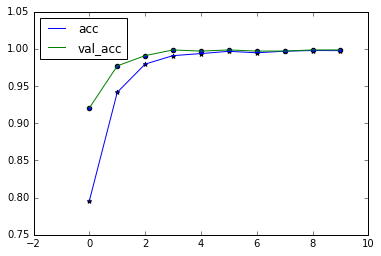

In [20]:
# plot the result
plt.figure
plt.plot(result.epoch,result.history['acc'],label="acc")
plt.plot(result.epoch,result.history['val_acc'],label="val_acc")
plt.scatter(result.epoch,result.history['acc'],marker='*')
plt.scatter(result.epoch,result.history['val_acc'])
plt.legend(loc='upper left')
plt.show()

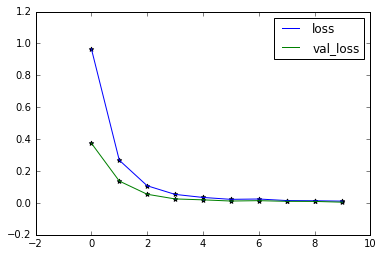

In [21]:
plt.figure
plt.plot(result.epoch,result.history['loss'],label="loss")
plt.plot(result.epoch,result.history['val_loss'],label="val_loss")
plt.scatter(result.epoch,result.history['loss'],marker='*')
plt.scatter(result.epoch,result.history['val_loss'],marker='*')
plt.legend(loc='upper right')
plt.show()